<h1>Simulation Based Inference (SBI)</h1>
<div class="text">
    <p>
    In this notebook I will explain the sbi package which is extensively used in this project. 
    <br>
    This tutorial is based on the one that can be found on the sbi-dev webiste. 
    However, here, the lines of code are combined in functions that closely resemble the structure and functions of my python scripts.
    </p>
    <p>
        In Astrophysics, Bayesian Inference is useful for calculating the value of the parameters which influenced a certain observation. In more details, it is used to calculate the posterior $p(\theta|x)$, which is the probability distribution of the parameters $\theta$ given the observation x. 
        <br>
        The posterior can be calculated using Bayes theorem:
    </p>
    <p>
        <center>
        $p(\theta|x) \propto p(x|\theta)\cdot p(\theta)$,
    </p>
    <p> 
        where $p(x|\theta)$ is the likelihood and $p(\theta)$ is the prior. However, to use this equation, we would need to know the likelihood. The issue is that it is not always possible to know the right equation of the likelihood, therefore approximations are often used. This is the case for intractable likelihoods, where the physical process is so complicated that it is difficult to know the true likelihood.
        <br>
        Instead, SBI uses Neural Networks, in particular Neural Density Estimators (NDE), to learn the likelihood or the posterior directly (this is why SBI is often also called likelihood-free inference).
    </p>
    <p>
        Since the true likelihood is not known, the NDE will learn by minimizing the Kullback-Liebler (KL) divergence (<a href="https://arxiv.org/abs/2305.03074">Prelogovic et al. 2023</a>), which in turn means minimizing the loss functions:
    </p>
        <p>
            <center>
                \[L = -\frac{1}{N}\sum_{i=1}^{N}\log\mathcal{L}_{NN}(d_{PS,i}|\theta)\]
        </p>
    <p>
    </p>
</div>

In [ ]:
import torch
from torch.optim import Adam
import sys
import os 

from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.neural_nets.net_builders import build_nsf
import matplotlib.pyplot as plt
import corner
import numpy as np
sys.path.insert(1, os.path.abspath('../')) # Note that this line is useless with a regular pip installation of PyWST.
#import pietrosbi as psbi

In [46]:
def simulator(theta):
    '''
    Simulator which is a linear gaussian

    Inputs:
        - theta: the set of paramters for the simulation

    Outputs:
        - The results of the simulator (same shape as theta)
    '''
    
    return theta + 1.0 + torch.randn_like(theta) * 0.1


In [ ]:


def simulate_data(prior, sim_func, num_simulations):
    """
    This function simulates the data

    Inputs:
        - sim_func: the function used to simulate the data
        - num_simulations: number of simulations

    Outputs:
        - theta: parameters of the simulations
        - x: data of the simulations
        - theta_true: parameters of the observation
        - x_obs: data of the observation
    """

    # Check prior, return PyTorch prior.
    prior, _, prior_returns_numpy = process_prior(prior)
    
    # Check simulator, returns PyTorch simulator able to simulate batches.
    sim_func = process_simulator(sim_func, prior, prior_returns_numpy)
    
    # Consistency check after making ready for sbi.
    check_sbi_inputs(sim_func, prior)

    # Generate random theta paramters
    theta = prior.sample((num_simulations,))
    
    # Create data with the simulator
    x = sim_func(theta)
    print("theta.shape", theta.shape)
    print("x.shape", x.shape)
    
    # Generate an observation
    theta_true = prior.sample((1,))
    x_obs = sim_func(theta_true)

    return theta, x, theta_true, x_obs


In [48]:
# Number of dimensions (or number of paramters theta)
num_dim = 3

# Prior of the parameters p(\theta). In this case a uniform distribution
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

# Number of simulations
num_simulations = 5000

theta, x, theta_true, x_obs = simulate_data(prior, simulator, num_simulations)

theta.shape torch.Size([5000, 3])
x.shape torch.Size([5000, 3])


<h2>Default method to train the NDE</h2>

In [ ]:
def create_posterior(theta, x, prior):
    '''
    It creates the Neural Posterior Estimator (NPE).
    It uses the data and parameters to train the the NPE 
    and create the posterior.

    Inputs:
        - theta: paramters of the simulations
        - x: data created by the simulator
        - prior: the prior of the parameters

    Output:
        - posterior: the learned posterior of the NPE
    '''

    # Create the NPE
    inference = NPE(prior=prior)

    # Append the simulations to the inference
    inference = inference.append_simulations(theta, x)

    # Training of the NPE
    density_estimator = inference.train()

    # Building the posterior
    posterior = inference.build_posterior(density_estimator)

    # Prints how the posterior was trained
    print(posterior) 

    return posterior

def my_cornerplot(samples, truths, labels, bins = 20, datapoints = True, smooth=True, limits=None):
    '''
    This function plots a cornerplot of the posterior.

    Inputs:
        - samples: datapoint sampled from the posterior
        - labels: labels of the plots
        - bins: bins for the distributions plotted on the diagonal
        - datapoints: whether or not to show the sample points
        - smooth: smoothin of the posterior
        - limits: limits of the plots

    Outputs: it draws the cornerplot
    '''
    
    fig = plt.figure(figsize = (8, 8))
    corner.corner(
        np.array(samples), 
        fig = fig, 
        color = "blue", 
        truths = truths, 
        levels = (0.68, 0.95), 
        plot_contour=False,
        plot_density=False,
        plot_datapoints=datapoints,
        fill_contours=True,
        smooth = smooth,
        bins = bins,
        labels = labels,
        range=limits
    )

    plt.show()

# Calculating the posterior
posterior = create_posterior(theta, x, prior)

# Sampling from the posterior conditioned on the observed data x_obs
samples = posterior.sample((10000,), x=x_obs)

 Neural network successfully converged after 99 epochs.Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

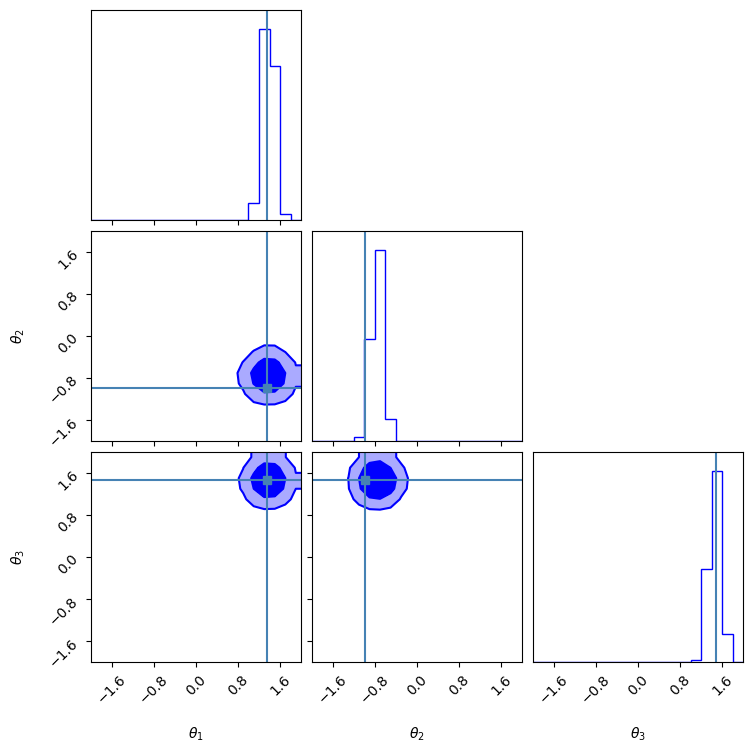

In [ ]:
# Plotting the posterior
my_cornerplot(samples, 
              truths = theta_true.flatten(), 
              labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"], 
              bins = 20, 
              datapoints = False, 
              smooth=True, 
              limits=[[-2, 2], [-2, 2], [-2, 2]]
             )

<h2>A more flexible denisty estimator</h2>
<div class="text">
    A similar code will be used for the training process on the 21cmfast simulations
</div>

In [ ]:
def create_posterior_2(theta, x, x_obs, epochs, num=10000):
    """
    This function calculates the posterior with a more advanced method

    Inputs:
        - theta: parameters of the simulations
        - x: data of the simualations
        - x_obs: observed data
        - epochs: number of epochs for the training
        - num: number of samples of the posterior

    Outputs:
        - samples: the samples of the posterior
    """

    # Create a NDE, which in this case in a Neural Spline Flaw (NSF)
    density_estimator = build_nsf(theta, x)
    
    # Choose an optimizer. In this case the Adam optimizer is used with learning rate = 5e-4
    opt = Adam(list(density_estimator.parameters()), lr=5e-4)

    # Training the NDE
    density_estimator = training_func(opt, density_estimator, theta, x, epochs)

    # Sampling from the trained NDE
    samples = sampling(density_estimator, x_obs, num)

    return samples
    
def training_func(opt, density_estimator, theta, x, epochs):
    """
    This function trains the NDE.

    Inputs:
        - opt: optimiser
        - density_estimator: the density estimator (NDE)
        - theta: parameters of the simulations
        - x: data of the simualations
        - epochs: number of epochs for the training

    Outputs:
        - density_estimator: the trained density estimator (NDE)
    """

    # Train the NDE with 200 epochs
    for _ in range(epochs):
        opt.zero_grad()
        losses = density_estimator.loss(theta, condition=x)
        loss = torch.mean(losses)
        loss.backward()
        opt.step()
        
    return density_estimator

def sampling(density_estimator, x_obs, num):
    """"
    This function samples from the trained density estimator.

    Inputs:
        - density_estimator: the density estimator (NDE)
        - x_obs: observed data
        - num: number of samples for the posterior
    
    Outputs:
        - samples: the samples of the posterior
    """
    # Sampling from the posterior
    samples = density_estimator.sample((num,), condition=x_obs).detach()
    print(f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension.")
    
    # Reshaping the samples tensor
    samples = samples.squeeze(dim=1)
    print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

    return samples



In [ ]:
# Setting the number of epochs
epochs = 200

# Training the NDE and sampling from the posterior
samples = create_posterior_2(theta, x, x_obs, epochs, num=10000)

Shape of samples: torch.Size([10000, 1, 3])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([10000, 3])     # Removed batch dimension.


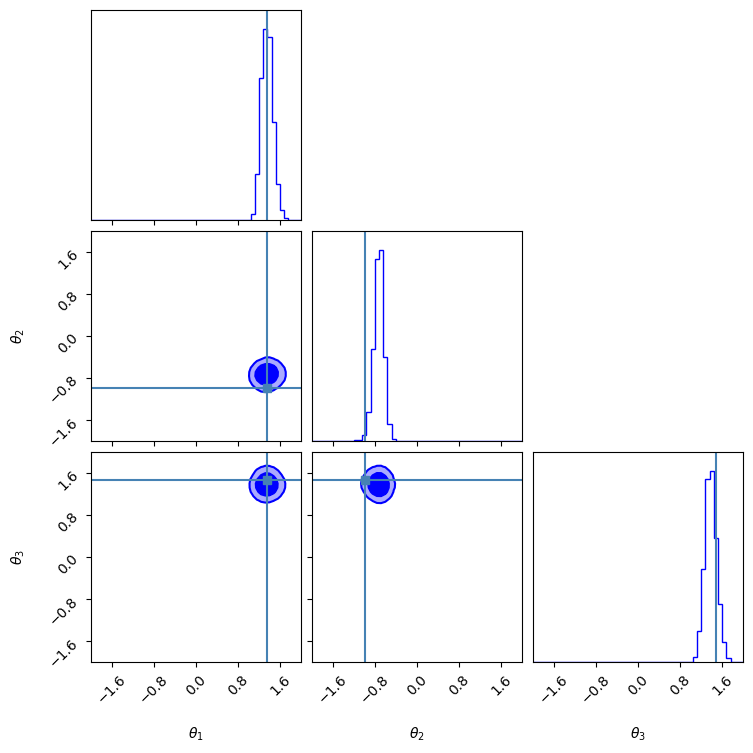

In [ ]:
# Plotting the posterior
my_cornerplot(samples,  
              truths = theta_true.flatten(),
              labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"], 
              bins = 50, 
              datapoints = False, 
              smooth=True, 
              limits=[[-2, 2], [-2, 2], [-2, 2]]
             )